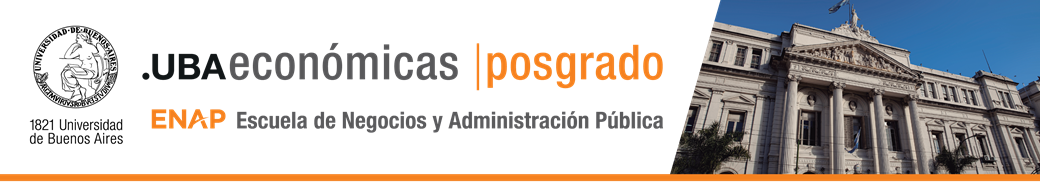

MAESTRÍA EN GESTIÓN Y ANÁLISIS DE DATOS FINANCIEROS (VIRTUAL)
# Métodos Predictivos Aplicados a Finanzas - Parte I (MPAFI)

Macarena Benjamin

**TP Clase 7**

Enunciado:
1. Producir en forma sintética con Python al menos 500.000 simulaciones de registros que contenga información sobre precios de opciones sobre la acción de Grupo Financiero Galicia (GGAL) simulando las siguientes variables:

* Precios del Subyacente
* Precios de Ejercicio
* Tiempo al Vencimiento
* Volatilidad
* Tasa Libre de Riesgo
* Tasa de Dividendos
* Tipo de Operación: Compra / Venta
* Tipo de Opción: Call / Put
* Precio de la Opción: Call / Put
* Volatilidad Implícita
* Volumen
1.1 Letras griegas:
* Delta
* Gamma
* Vega
* Rho
* Theta


Cada variable simulada debe tener consistencia y concordancia con el rango de
posibles valores que el activo financiero asumió en los últimos 2 (dos) años. Justificar cada decisión tomada.


2. Entrenar distintas redes (ANN, MLP y LSTM) con los datos sintéticos separando entre datos de entrenamiento, de testing y de validación (en caso de corresponder) para predecir el precio de la opción (call o put en caso de corresponder). Tienen libertad para elegir la mejor estrategia para optimizar hiperparametros, visualizar distintos resultados, normalizar los datos de entrada de la red, etc.


3. Verificar el score obtenido de cada modelo mediante la misma métrica. Justificar los resultados y la elección de la métrica.

# **Ejercicio 1**

## **Referencia de precios históricos de GGAL con ventana 2 años**

Valor de la accion Galicia para los ultimos dos años (las simulaciones deben tener esto de referencia)

In [ ]:
import yfinance as yf
import datetime

# Definir el ticker de GGAL (Grupo Financiero Galicia)
ticker = "GGAL"

# Definir la ventana temporal de 2 años
end_date = datetime.datetime.today()
start_date = end_date - datetime.timedelta(days=2*365)

# Descargar datos históricos de precios
data = yf.download(ticker, start=start_date, end=end_date)

# Mostrar las primeras filas
data.head()


YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Ticker,GGAL,GGAL,GGAL,GGAL,GGAL
Date,,,,,
2023-05-30,10.426558,10.452389,9.772209,9.987455,326300
2023-05-31,10.617985,10.743218,10.242285,10.394354,576200
2023-06-01,10.814782,10.984741,10.492753,10.582206,337500
2023-06-02,10.573261,11.047359,10.537480,10.957906,324900
2023-06-05,11.029467,11.065248,10.412246,10.528534,468500


In [ ]:
# Interpretar precios maximos y minimos durante el periodo seleccionado
max_price = data['High'].max()
max_date = data['High'].idxmax()

min_price = data['Low'].min()
min_date = data['Low'].idxmin()


print(f"Precio máximo: {max_price.iloc[0]:.2f} USD en {max_date.iloc[0].date()}")
print(f"Precio mínimo: {min_price.iloc[0]:.2f} USD en {min_date.iloc[0].date()}")

Precio máximo: 74.00 USD en 2025-01-07
Precio mínimo: 9.77 USD en 2023-05-30


## **Simulaciones**

In [ ]:
import numpy as np
import pandas as pd
from scipy.stats import norm

# Modelo Black-Scholes
def black_scholes(S, K, T, r, sigma, option_type='call', q=0.0):
    if T == 0:
        return max(0, S - K) if option_type == 'call' else max(0, K - S)
    d1 = (np.log(S / K) + (r - q + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    if option_type == 'call':
        return S * np.exp(-q * T) * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    else:
        return K * np.exp(-r * T) * norm.cdf(-d2) - S * np.exp(-q * T) * norm.cdf(-d1)


# Letras griegas
def greeks(S, K, T, r, sigma, option_type='call', q=0.0):
    if T == 0:
        return dict(Delta=0, Gamma=0, Vega=0, Rho=0, Theta=0)
    d1 = (np.log(S / K) + (r - q + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    delta = np.exp(-q * T) * norm.cdf(d1) if option_type == 'call' else np.exp(-q * T) * (norm.cdf(d1) - 1)
    gamma = np.exp(-q * T) * norm.pdf(d1) / (S * sigma * np.sqrt(T))
    vega = S * np.exp(-q * T) * norm.pdf(d1) * np.sqrt(T)
    rho = (K * T * np.exp(-r * T) * norm.cdf(d2)) if option_type == 'call' else (-K * T * np.exp(-r * T) * norm.cdf(-d2))
    theta_call = (-S * sigma * np.exp(-q * T) * norm.pdf(d1) / (2 * np.sqrt(T))
                  + q * S * np.exp(-q * T) * norm.cdf(d1)
                  - r * K * np.exp(-r * T) * norm.cdf(d2))
    theta_put = (-S * sigma * np.exp(-q * T) * norm.pdf(d1) / (2 * np.sqrt(T))
                 - q * S * np.exp(-q * T) * norm.cdf(-d1)
                 + r * K * np.exp(-r * T) * norm.cdf(-d2))
    theta = theta_call if option_type == 'call' else theta_put
    return dict(Delta=delta, Gamma=gamma, Vega=vega, Rho=rho, Theta=theta)

# Número de simulaciones
n = 500_000
np.random.seed(2025)

# Simulaciones de variables básicas
S = np.random.uniform(9.77, 74.00, size=n) # Precio del subyacente --> Este precio no debe exceder los precios minimos y maximos que tuvo la accion GGAL los últimos 2 años
K = S * np.random.uniform(0.8, 1.2, size=n) # Precio de ejercicio (ATM ± 20%)
T = np.random.uniform(1/252, 2, size=n) # Tiempo al vencimiento (1 día a 2 años)
r = np.random.uniform(0.02, 0.07, size=n) # Tasa libre de riesgo (2%-7%)
q = np.random.uniform(0.00, 0.04, size=n) # Tasa de dividendos (0%-4%)
sigma = np.random.uniform(0.20, 0.80, size=n) # Volatilidad (20%-80%)
option_type = np.random.choice(['call', 'put'], size=n)  # Tipo de opción (call o put)
operation_type = np.random.choice(['compra', 'venta'], size=n) # Tipo de operación (compra o venta)
volume = np.random.poisson(lam=50, size=n) + 1  # Volumen (evitar 0)
IV = sigma + np.random.normal(0, 0.05, size=n) # Volatilidad implícita (desviación leve)

# Precios de opción y letras griegas
option_price = np.empty(n)
delta = np.empty(n)
gamma = np.empty(n)
vega = np.empty(n)
rho = np.empty(n)
theta = np.empty(n)

for i in range(n):
    option_price[i] = black_scholes(S[i], K[i], T[i], r[i], sigma[i], option_type[i], q[i])
    g = greeks(S[i], K[i], T[i], r[i], sigma[i], option_type[i], q[i])
    delta[i] = g['Delta']
    gamma[i] = g['Gamma']
    vega[i] = g['Vega']
    rho[i] = g['Rho']
    theta[i] = g['Theta']

# Construir DataFrame final
df = pd.DataFrame({
    "Precio_Subyacente": S,
    "Precio_Ejercicio": K,
    "Tiempo_al_Vencimiento": T,
    "Volatilidad": sigma,
    "Tasa_Libre_de_Riesgo": r,
    "Tasa_Dividendos": q,
    "Tipo_Operacion": operation_type,
    "Tipo_Opcion": option_type,
    "Precio_Opcion": option_price,
    "Volatilidad_Implicita": IV,
    "Volumen": volume,
    "Delta": delta,
    "Gamma": gamma,
    "Vega": vega,
    "Rho": rho,
    "Theta": theta
})

df.head()


,Precio_Subyacente,Precio_Ejercicio,Tiempo_al_Vencimiento,Volatilidad,Tasa_Libre_de_Riesgo,Tasa_Dividendos,Tipo_Operacion,Tipo_Opcion,Precio_Opcion,Volatilidad_Implicita,Volumen,Delta,Gamma,Vega,Rho,Theta
0,18.472405,21.808706,0.072814,0.324140,0.053879,0.030679,compra,call,0.020417,0.375576,61,0.033165,0.045734,0.368331,0.043122,-0.832948
1,66.796715,57.734534,1.701507,0.318810,0.051954,0.010817,compra,call,17.377875,0.335608,67,0.752361,0.010827,26.204222,55.941061,-3.619427
2,69.671260,60.688514,1.705115,0.632527,0.043544,0.018660,compra,call,25.852663,0.593664,43,0.713079,0.005502,28.802797,40.630300,-5.452858
3,38.388843,36.353565,0.330623,0.780749,0.060983,0.019934,venta,call,7.878634,0.824647,46,0.642309,0.021427,8.151054,5.547483,-10.155819
4,34.706369,38.717667,1.666907,0.251005,0.031077,0.011132,compra,call,3.335434,0.254159,53,0.462297,0.034726,17.501024,21.185085,-1.534029


In [ ]:
# Guardar simulacion en el drive
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
# Ruta
df.to_csv('/content/drive/MyDrive/simulacion_opciones.csv', index=False)

# **Ejercicio 2**

## **Preparacion de los datos**

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam

In [ ]:
# Leer datos
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd
df = pd.read_csv('/content/drive/MyDrive/simulacion_opciones.csv')
df.head()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,Precio_Subyacente,Precio_Ejercicio,Tiempo_al_Vencimiento,Volatilidad,Tasa_Libre_de_Riesgo,Tasa_Dividendos,Tipo_Operacion,Tipo_Opcion,Precio_Opcion,Volatilidad_Implicita,Volumen,Delta,Gamma,Vega,Rho,Theta
0,18.472405,21.808706,0.072814,0.324140,0.053879,0.030679,compra,call,0.020417,0.375576,61,0.033165,0.045734,0.368331,0.043122,-0.832948
1,66.796715,57.734534,1.701507,0.318810,0.051954,0.010817,compra,call,17.377875,0.335608,67,0.752361,0.010827,26.204222,55.941061,-3.619427
2,69.671260,60.688514,1.705115,0.632527,0.043544,0.018660,compra,call,25.852663,0.593664,43,0.713079,0.005502,28.802797,40.630300,-5.452858
3,38.388843,36.353565,0.330623,0.780749,0.060983,0.019934,venta,call,7.878634,0.824647,46,0.642309,0.021427,8.151054,5.547483,-10.155819
4,34.706369,38.717667,1.666907,0.251005,0.031077,0.011132,compra,call,3.335434,0.254159,53,0.462297,0.034726,17.501024,21.185085,-1.534029


In [ ]:
#Se aplica dummies a las variables categoricas
df = pd.get_dummies(df, dtype=int)
df.head()

,Precio_Subyacente,Precio_Ejercicio,Tiempo_al_Vencimiento,Volatilidad,Tasa_Libre_de_Riesgo,Tasa_Dividendos,Precio_Opcion,Volatilidad_Implicita,Volumen,Delta,Gamma,Vega,Rho,Theta,Tipo_Operacion_compra,Tipo_Operacion_venta,Tipo_Opcion_call,Tipo_Opcion_put
0,18.472405,21.808706,0.072814,0.324140,0.053879,0.030679,0.020417,0.375576,61,0.033165,0.045734,0.368331,0.043122,-0.832948,1,0,1,0
1,66.796715,57.734534,1.701507,0.318810,0.051954,0.010817,17.377875,0.335608,67,0.752361,0.010827,26.204222,55.941061,-3.619427,1,0,1,0
2,69.671260,60.688514,1.705115,0.632527,0.043544,0.018660,25.852663,0.593664,43,0.713079,0.005502,28.802797,40.630300,-5.452858,1,0,1,0
3,38.388843,36.353565,0.330623,0.780749,0.060983,0.019934,7.878634,0.824647,46,0.642309,0.021427,8.151054,5.547483,-10.155819,0,1,1,0
4,34.706369,38.717667,1.666907,0.251005,0.031077,0.011132,3.335434,0.254159,53,0.462297,0.034726,17.501024,21.185085,-1.534029,1,0,1,0


In [ ]:
#Se normalizan los datos entre 0 y 1
df = (df - df.min()) / (df.max() - df.min())
df.head()

,Precio_Subyacente,Precio_Ejercicio,Tiempo_al_Vencimiento,Volatilidad,Tasa_Libre_de_Riesgo,Tasa_Dividendos,Precio_Opcion,Volatilidad_Implicita,Volumen,Delta,Gamma,Vega,Rho,Theta,Tipo_Operacion_compra,Tipo_Operacion_venta,Tipo_Opcion_call,Tipo_Opcion_put
0,0.135487,0.172817,0.034487,0.206896,0.677584,0.766974,0.000535,0.368897,0.541667,0.516582,0.030509,0.009048,0.597652,0.966633,1.0,0.0,1.0,0.0
1,0.887856,0.616687,0.850459,0.198014,0.639090,0.270437,0.455538,0.328104,0.625000,0.876181,0.007222,0.643735,0.874227,0.950973,1.0,0.0,1.0,0.0
2,0.932610,0.653184,0.852266,0.720879,0.470875,0.466501,0.677693,0.591485,0.291667,0.856540,0.003670,0.707572,0.798472,0.940669,1.0,0.0,1.0,0.0
3,0.445570,0.352521,0.163649,0.967916,0.819655,0.498359,0.206528,0.827234,0.333333,0.821155,0.014294,0.200239,0.624887,0.914238,0.0,1.0,1.0,0.0
4,0.388236,0.381730,0.833124,0.085004,0.221544,0.278290,0.087434,0.244974,0.430556,0.731148,0.023165,0.429931,0.702260,0.962693,1.0,0.0,1.0,0.0


In [ ]:
#Convertir a float32 para usar GPU
df = df.astype(np.float32)

df.dtypes

,0
Precio_Subyacente,float32
Precio_Ejercicio,float32
Tiempo_al_Vencimiento,float32
Volatilidad,float32
Tasa_Libre_de_Riesgo,float32
Tasa_Dividendos,float32
Precio_Opcion,float32
Volatilidad_Implicita,float32
Volumen,float32
Delta,float32


In [ ]:
# Separar features y target
X = df.drop(columns=['Precio_Opcion'])
y = df['Precio_Opcion']

In [ ]:
# Conjuntos: entrenamiento y test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2025)


## **Modelo ANN-MLP**

MLP (Multilayer Perceptron) es un tipo específico de ANN (Artificial Neural Network) una red feedforward totalmente conectada con una o más capas ocultas.


* Tiene múltiples capas densas
* Es totalmente conectada (cada neurona de una capa se conecta a todas las de la siguiente)
* No tiene memoria ni conexiones recurrentes (no es una RNN o LSTM)
* No tiene convoluciones (no es una CNN)

In [ ]:
# Modelo ANN-MLP
def build_ann(input_dim):
    model = Sequential([
        Input(shape=(input_dim,)),
        Dense(128, activation='relu'),
        Dropout(0.3),
        Dense(64, activation='relu'),
        Dense(32, activation='relu'),
        Dense(1)  # Salida para regresión
    ])
    model.compile(optimizer=Adam(1e-3), loss='mse', metrics=['mae'])
    return model

ann = build_ann(X_train.shape[1])


ann.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_2 (Dense)                 │ (None, 128)            │         2,304 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,673 (49.50 KB)

 Trainable params: 12,673 (49.50 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Entrenamiento
ann.fit(X_train, y_train, epochs=30, batch_size=512, verbose=1)

Epoch 1/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - loss: 0.0196 - mae: 0.0896
Epoch 2/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0017 - mae: 0.0304
Epoch 3/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0010 - mae: 0.0236
Epoch 4/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 7.5209e-04 - mae: 0.0201
Epoch 5/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 5.6547e-04 - mae: 0.0174
Epoch 6/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 4.3242e-04 - mae: 0.0152
Epoch 7/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 3.2608e-04 - mae: 0.0130
Epoch 8/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 2.5244e-04 - mae: 0.0114
Epoch 9/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 2.0344e-04 - mae: 0.0101
Epoch 10/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 1.6529e-04 - mae: 0.0091
Epoch 11/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 1.4352e-04 - mae: 0.0084
Epoch 12/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 1.2424e-04 - m

In [ ]:
# Predicciones
y_pred = ann.predict(X_test).flatten()

3125/3125 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step


In [ ]:
# Evaluación
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))


print(f"MAE  (Error absoluto medio):     {mae:.4f}")
print(f"RMSE (Raíz error cuadrático):   {rmse:.4f}")



MAE  (Error absoluto medio):     0.0862
RMSE (Raíz error cuadrático):   0.0905


## **Modelo LSTM**

Las LSTM requieren datos en forma de secuencias, por ejemplo: usar los últimos 3 días para predecir el siguiente.

In [ ]:
def create_sequences(X, y, window_size=3):
    X_seq, y_seq = [], []
    for i in range(len(X) - window_size):
        X_seq.append(X[i:i+window_size])
        y_seq.append(y[i+window_size])
    return np.array(X_seq), np.array(y_seq)

In [ ]:
X_seq, y_seq = create_sequences(X, y, window_size=3)
print(X_seq.shape)

(499997, 3, 17)


In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_seq, y_seq, test_size=0.2, random_state=2025)


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers



def build_lstm(input_shape):
    model = Sequential([
        LSTM(128, return_sequences=True, input_shape=input_shape, kernel_regularizer=regularizers.l2(1e-4)),
        BatchNormalization(),
        Dropout(0.3),

        LSTM(64, kernel_regularizer=regularizers.l2(1e-4)),
        BatchNormalization(),
        Dropout(0.2),

        Dense(32, activation='relu'),
        Dense(1)  # regresión
    ])
    model.compile(optimizer=Adam(1e-4), loss='mse', metrics=['mae'])
    return model


lstm = build_lstm((X_train.shape[1], X_train.shape[2]))
lstm.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_3 (LSTM)                   │ (None, 3, 128)         │        74,752 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 3, 128)         │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 3, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_4 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 127,041 (496.25 KB)

 Trainable params: 126,657 (494.75 KB)

 Non-trainable params: 384 (1.50 KB)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(patience=5, restore_best_weights=True)

# Entrenamiento

lstm.fit(X_train, y_train,
         epochs=30, batch_size=512,
         callbacks=[early_stop], verbose=1)

Epoch 1/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 12s 11ms/step - loss: 0.2965 - mae: 0.3976
Epoch 2/30
 13/782 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - loss: 0.0981 - mae: 0.2204

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae
  current = self.get_monitor_value(logs)


782/782 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step - loss: 0.0827 - mae: 0.1978
Epoch 3/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - loss: 0.0571 - mae: 0.1547
Epoch 4/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - loss: 0.0468 - mae: 0.1361
Epoch 5/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - loss: 0.0415 - mae: 0.1283
Epoch 6/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - loss: 0.0379 - mae: 0.1247
Epoch 7/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - loss: 0.0350 - mae: 0.1231
Epoch 8/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step - loss: 0.0323 - mae: 0.1222
Epoch 9/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - loss: 0.0300 - mae: 0.1218
Epoch 10/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - loss: 0.0282 - mae: 0.1220
Epoch 11/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 11s 9ms/step - loss: 0.0265 - mae: 0.1213
Epoch 12/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - loss: 0.0255 - mae: 0.1217
Epoch 13/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - loss: 0.0246 - mae: 0.1213
Epoch 14/30
782/782 ━━━━

In [ ]:
# Predicciones
y_pred = lstm.predict(X_test).flatten()

3125/3125 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step


In [ ]:
# Evaluación

from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))


print(f"MAE: {mae:.4f}")
print(f"RMSE: {rmse:.4f}")



MAE: 0.1214
RMSE: 0.1518


# **Conclusiones**

Este trabajo explora la aplicación de Redes Neuronales Artificiales Multicapa (ANN-MLP) y Redes de Memoria a Largo Plazo (LSTM) para predecir el precio de opciones financieras, utilizando un extenso conjunto de datos sintéticos generados a partir de simulaciones basadas en el modelo Black-Scholes y letras griegas. Ambos modelos fueron entrenados y evaluados con el objetivo de determinar su capacidad para predecir el "Precio_Opcion".

El modelo ANN-MLP se configuró como una red neuronal feed-forward con múltiples capas densas, utilizando ReLU como función de activación y Dropout para prevenir el sobreajuste. Se entrenó con el optimizador Adam y MSE como función de pérdida. La baja puntuación del RMSE es un indicador clave del buen rendimiento del modelo ANN-MLP. Dado que los datos fueron normalizados en un rango de 0 a 1, estos errores representan una fracción muy pequeña del rango total de los precios de las opciones, lo que sugiere que las predicciones del modelo están consistentemente cerca de los valores reales. Esto demuestra que la red ANN-MLP, a pesar de su naturaleza no secuencial, es capaz de aprender las relaciones complejas presentes en los datos de entrada y realizar predicciones precisas para el precio de la opción. La inclusión de capas de Dropout fue crucial para mantener la capacidad de generalización del modelo.

El modelo LSTM, diseñado específicamente para manejar secuencias de datos, se construyó con múltiples capas LSTM, utilizando BatchNormalization y Dropout para mejorar la estabilidad y prevenir el sobreajuste. La arquitectura incluyó capas LSTM con return_sequences=True para apilamiento, seguidas de capas densas. Se entrenó con el optimizador Adam (con una tasa de aprendizaje ligeramente menor) y MSE como función de pérdida. Aunque el modelo LSTM está conceptualmente mejor adaptado para manejar datos secuenciales (como series temporales), en este caso específico, sus métricas de error (MAE y RMSE) fueron ligeramente superiores en comparación con el modelo ANN-MLP. Esto podría deberse a varios factores:
* Naturaleza de los datos sintéticos: Aunque los datos son simulaciones de registros que contienen información de diferentes variables a lo largo del tiempo si la relación entre los puntos de datos no es fuertemente secuencial o si la memoria del LSTM no fue completamente aprovechada con la ventana definida, un modelo feed-forward como el ANN-MLP podría desempeñarse mejor al no tener que aprender dependencias temporales que quizás no sean tan pronunciadas en la forma en que se estructuraron las entradas para la LSTM.
* Complejidad del modelo: A veces, un modelo más simple puede ser más efectivo si la complejidad inherente de los datos no requiere una arquitectura más avanzada. El ANN-MLP pudo haber capturado las relaciones sin la necesidad de la "memoria" secuencial de la LSTM.
* Optimización de hiperparámetros: Si bien ambos modelos fueron entrenados con parámetros razonables, una optimización más exhaustiva de los hiperparámetros específicos para cada arquitectura podría haber influido en los resultados. Es posible que el ANN-MLP haya alcanzado un mejor punto de rendimiento con la configuración dada.

Ambos modelos demuestran una capacidad prometedora para predecir el precio de las opciones basándose en los datos sintéticos generados. Sin embargo, en este escenario particular, el modelo ANN-MLP superó ligeramente al modelo LSTM en términos de precisión de predicción (menores valores de MAE y RMSE). Esto resalta que, a pesar de que las LSTMs son potentes para secuencias, un MLP bien configurado puede ser muy efectivo para tareas de regresión cuando las características de entrada ya contienen suficiente información para predecir la salida, independientemente de su orden temporal intrínseco.



# **Anexo**

link al informe: https://docs.google.com/document/d/1g3a1iWBadzYCZsXVRUDwgpkQmC4kq0tQeqVMdJ-7pl4/edit?usp=sharing  